# Examples of using the draft package 'propensity_reweighting'

In [1]:
from propensity_reweighting.src.reweight import PropensityReweighter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import logging
import yaml

logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
np.random.seed(48)

In [2]:
with open('./propensity_reweighting/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# texts = pd.read_csv('/workspace/local/edl/llm_propensity/qa_data_gpt_llama.csv')
texts = pd.read_csv('./llm_propensity/QA_version_0506 - Sheet1.csv')

## Base 'fit' method

In [3]:
original = texts[texts["Time"] == 'original']["Question"].tolist()
target = texts[texts["Time"] == 'future']["Question"].tolist()

In [4]:
from propensity_reweighting.src.reweight import PropensityReweighter

pr = PropensityReweighter(config)
_ = pr.fit(original, target)

Mean k2 on non-weighted test data: 0.2353
Mean EMD on non-weighted test data: 0.0662
Mean ED on non-weighted test data: 0.1332

Mean k2 on weighted test data: 0.1955
Mean EMD on weighted test data: 0.0537
Mean ED on weighted test data: 0.1077



In [5]:
weights = pr.predict(target)
weights[:10]

array([1.82027115, 1.57874549, 1.82027115, 1.89444131, 1.45053357,
       1.4528157 , 1.66747493, 1.57904128, 1.6913386 , 1.62518438])

Text(0.5, 1.0, 'predicted weights')

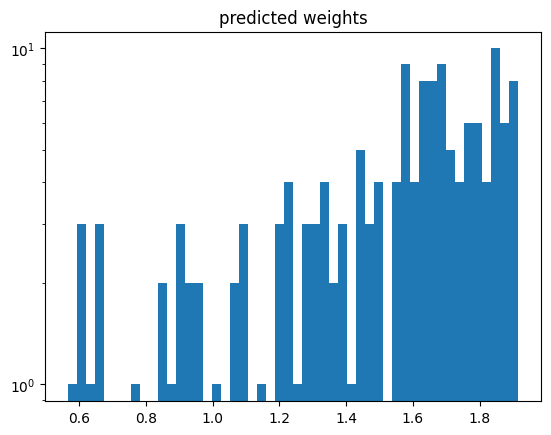

In [6]:
plt.hist(weights, bins=50)
plt.yscale('log')
plt.title('predicted weights')

## 'fit' with custom GridSearchCV 

In [3]:
original = texts[texts["Time"] == 'original']["Question"].tolist()
target = texts[texts["Time"] == 'future']["Question"].tolist()

In [4]:
from propensity_reweighting.src.reweight import PropensityReweighter

grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

pr = PropensityReweighter(config)
best_predictor = pr.fit_gridsearch(original, target, grid_values)

  0%|          | 0/36 [00:00<?, ?it/s]

Results:
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 1}, 0.027573379091440448)
({'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 10}, 0.026775148148576972)
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 10}, 0.026429746813873334)
({'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 10, 'min_samples_leaf': 10}, 0.026383393071299232)
({'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'min_samples_leaf': 1}, 0.025435030131440977)
Best Parameters: {'n_estimators': 100, 'learning_rate': 0.009, 'max_depth': 5, 'min_samples_leaf': 1}
Error: 0.027573379091440448

Mean k2 on non-weighted test data: 0.2353
Mean EMD on non-weighted test data: 0.0662
Mean ED on non-weighted test data: 0.1332

Mean k2 on weighted test data: 0.1591
Mean EMD on weighted test data: 0.0386
Mean ED on weighted test data: 0.0765



In [5]:
best_weights = best_predictor.predict(target)
best_weights[:10]

array([1.30878491, 5.73613099, 2.28492   , 6.115655  , 5.32396158,
       1.85894275, 1.92759861, 2.58848909, 6.07864215, 1.93103268])

Text(0.5, 1.0, 'predicted weights')

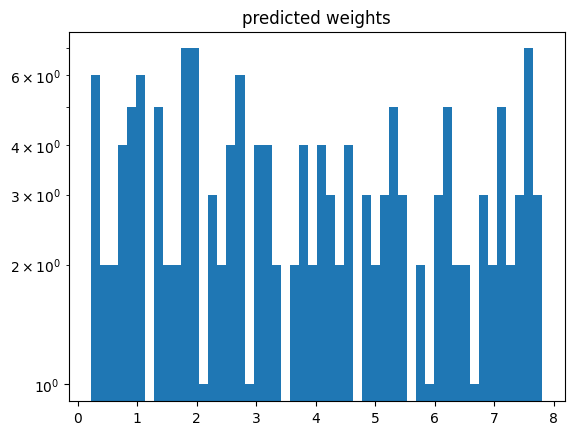

In [6]:
plt.hist(best_weights, bins=50)
plt.yscale('log')
plt.title('predicted weights')

## future's and past's analysis from QA data

In [4]:
original = texts[texts["unit"] == 'original']["Question"].tolist()

results = {}
for i in tqdm(range(1, 8)):
    cur_shift = f'past-{i}'
    target = texts[texts["unit"] == cur_shift]["Question"].tolist()
    target_train, target_test  = target[:len(target) // 3], target[len(target) // 3:]
    labels = [texts[texts["unit"] == cur_shift]["gpt3_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["gpt4_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["llama2_is_correct"].tolist()[len(target) // 3:],
             texts[texts["unit"] == cur_shift]["llama3_is_correct"].tolist()[len(target) // 3:]]
    
    grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

    pr = PropensityReweighter(config)
    best_predictor = pr.fit_gridsearch(original, target_train, grid_values)
    
    best_weights = best_predictor.predict(target_test)
    
    accuracy_all = []
    f1_all = []
    f1_all.append(f"{len(target_train)} / {len(target_test)}")
    for model_pred in labels:
        # ac = round(accuracy_score([1] * len(model_pred), model_pred), 3), round(accuracy_score([1] * len(model_pred), model_pred, sample_weight=best_weights), 3)
        f1 = round(f1_score([1] * len(model_pred), model_pred), 3), round(f1_score([1] * len(model_pred), model_pred, sample_weight=best_weights), 3)
        
        # accuracy_all.append(f"{ac[0]} - {ac[1]}")
        f1_all.append(f"{f1[0]} / {f1[1]}")
        
    # results[cur_shift] = {'accuracy': accuracy_all, 'f1-score': f1_all}
    results[cur_shift] = {'f1-score': f1_all}

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.4471
Mean EMD on non-weighted test data: 0.1307
Mean ED on non-weighted test data: 0.2591

Mean k2 on weighted test data: 0.3759
Mean EMD on weighted test data: 0.0991
Mean ED on weighted test data: 0.2025



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.5446
Mean EMD on non-weighted test data: 0.1587
Mean ED on non-weighted test data: 0.3206

Mean k2 on weighted test data: 0.5297
Mean EMD on weighted test data: 0.153
Mean ED on weighted test data: 0.3087



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.6295
Mean EMD on non-weighted test data: 0.1695
Mean ED on non-weighted test data: 0.3596

Mean k2 on weighted test data: 0.6033
Mean EMD on weighted test data: 0.1593
Mean ED on weighted test data: 0.3366



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.615
Mean EMD on non-weighted test data: 0.1625
Mean ED on non-weighted test data: 0.3474

Mean k2 on weighted test data: 0.6
Mean EMD on weighted test data: 0.1599
Mean ED on weighted test data: 0.3383



Exception ignored in: <function tqdm.__del__ at 0x7fd715d088b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tqdm/std.py", line 1161, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [9]:
df = pd.DataFrame([], columns=["shift", "num_samples", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])

for item in results:
    df = pd.concat(
        [df, pd.DataFrame([[item, results[item]["f1-score"][0],
                            results[item]["f1-score"][1], 
                            results[item]["f1-score"][2], 
                            results[item]["f1-score"][3],
                            results[item]["f1-score"][4]]], columns=["shift", "num_samples", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])],
        ignore_index=True,)

In [5]:
# target_test
df

,shift,num_samples,f1_gpt3,f1_gpt4,f1_llama2,f1_llama3
0,future+1,10 / 22,0.872 / 0.868,0.778 / 0.815,0.429 / 0.509,0.625 / 0.406
1,future+2,7 / 15,0.846 / 0.836,0.929 / 0.913,0.571 / 0.609,0.696 / 0.681
2,future+3,5 / 12,0.857 / 0.733,0.8 / 0.715,0.4 / 0.349,0.588 / 0.568
3,future+4,4 / 8,0.857 / 0.58,0.769 / 0.895,0.222 / 0.176,0.769 / 0.893
4,future+5,3 / 8,0.857 / 0.862,0.667 / 0.674,0.545 / 0.486,0.667 / 0.674
5,future+6,3 / 6,0.8 / 0.799,0.667 / 0.633,0.5 / 0.482,0.5 / 0.482
6,future+7,2 / 6,0.8 / 0.855,0.909 / 0.927,0.667 / 0.758,0.8 / 0.855


In [10]:
# past_test
df

,shift,num_samples,f1_gpt3,f1_gpt4,f1_llama2,f1_llama3
0,past-1,6 / 14,0.923 / 0.942,0.923 / 0.837,0.526 / 0.491,0.783 / 0.746
1,past-2,4 / 9,0.8 / 0.684,0.875 / 0.761,0.615 / 0.512,0.364 / 0.291
2,past-3,3 / 6,0.8 / 0.825,0.8 / 0.825,0.0 / 0.0,0.667 / 0.688
3,past-4,3 / 6,0.8 / 0.81,0.8 / 0.81,0.286 / 0.235,0.8 / 0.81
4,past-5,1 / 4,0.667 / 0.443,0.857 / 0.787,0.0 / 0.0,0.4 / 0.249
5,past-6,1 / 2,0.667 / 0.447,0.667 / 0.447,0.0 / 0.0,0.667 / 0.447
6,past-7,1 / 2,0.667 / 0.845,0.667 / 0.845,0.0 / 0.0,0.667 / 0.845


In [8]:
df = pd.DataFrame([], columns=["shift", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])

for item in results:
    df = pd.concat(
        [df, pd.DataFrame([[item, results[item]["f1-score"][0],
                            results[item]["f1-score"][1], 
                            results[item]["f1-score"][2], 
                            results[item]["f1-score"][3]]], columns=["shift", "f1_gpt3", "f1_gpt4", "f1_llama2", "f1_llama3"])],
        ignore_index=True,)

In [9]:
df

,shift,f1_gpt3,f1_gpt4,f1_llama2,f1_llama3
0,past-1,0.857 / 0.939,0.824 / 0.832,0.462 / 0.567,0.788 / 0.594
1,past-2,0.818 / 0.916,0.762 / 0.851,0.471 / 0.659,0.471 / 0.661
2,past-3,0.8 / 0.905,0.714 / 0.841,0.0 / 0.617,0.8 / 0.658
3,past-4,0.8 / 0.906,0.714 / 0.84,0.5 / 0.63,0.714 / 0.659
4,past-5,0.75 / 0.934,0.889 / 0.835,0.0 / 0.467,0.333 / 0.523
5,past-6,0.8 / 0.92,0.8 / 0.84,0.0 / 0.625,0.8 / 0.752
6,past-7,0.5 / 0.865,0.8 / 0.79,0.0 / 0.552,0.5 / 0.625


## future's and past's analysis from updated QA data

In [43]:
original = texts[texts["Unit"] == 'Original']["Question"].tolist()
labels = [texts[texts["Unit"] == 'Original']["gpt4score"].tolist(),
             texts[texts["Unit"] == 'Original']["gpt3.5score"].tolist()]

results = {}
for i in tqdm(range(1, 9)):
    cur_shift = f'Future+{i}'
    target = texts[texts["Unit"] == cur_shift]["Question"].tolist()
    true_target_labels = [texts[texts["Unit"] == cur_shift]["gpt4score"].tolist(),
             texts[texts["Unit"] == cur_shift]["gpt3.5score"].tolist()]
    
    grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

    pr = PropensityReweighter(config)
    best_predictor = pr.fit_gridsearch(original, target, grid_values)
    
    best_weights = best_predictor.predict(original)
    
    accuracy_all = []
    f1_all = []
    f1_all.append(f"{len(target)}")
    for j, model_pred in enumerate(labels):
        f1 = round(f1_score([5] * len(true_target_labels[j]), true_target_labels[j], sample_weight=([1] * len(true_target_labels[j])), average='weighted'), 3), round(f1_score([5] * len(model_pred), model_pred, sample_weight=best_weights, average='weighted'), 3)
        f1_all.append(f"{f1[0]} / {f1[1]}")
        
    results[cur_shift] = {'f1-score': f1_all}

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.0876
Mean EMD on non-weighted test data: 0.0196
Mean ED on non-weighted test data: 0.0393

Mean k2 on weighted test data: 0.0873
Mean EMD on weighted test data: 0.0196
Mean ED on weighted test data: 0.039



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.107
Mean EMD on non-weighted test data: 0.0256
Mean ED on non-weighted test data: 0.0504

Mean k2 on weighted test data: 0.1043
Mean EMD on weighted test data: 0.0248
Mean ED on weighted test data: 0.0488



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.1252
Mean EMD on non-weighted test data: 0.0322
Mean ED on non-weighted test data: 0.0622

Mean k2 on weighted test data: 0.122
Mean EMD on weighted test data: 0.0311
Mean ED on weighted test data: 0.0601



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.1319
Mean EMD on non-weighted test data: 0.0346
Mean ED on non-weighted test data: 0.0662

Mean k2 on weighted test data: 0.1295
Mean EMD on weighted test data: 0.033
Mean ED on weighted test data: 0.0633



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.1422
Mean EMD on non-weighted test data: 0.0374
Mean ED on non-weighted test data: 0.0716

Mean k2 on weighted test data: 0.1367
Mean EMD on weighted test data: 0.0354
Mean ED on weighted test data: 0.0681



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.1716
Mean EMD on non-weighted test data: 0.0479
Mean ED on non-weighted test data: 0.0911

Mean k2 on weighted test data: 0.1597
Mean EMD on weighted test data: 0.0425
Mean ED on weighted test data: 0.0812



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.2084
Mean EMD on non-weighted test data: 0.0584
Mean ED on non-weighted test data: 0.1119

Mean k2 on weighted test data: 0.2018
Mean EMD on weighted test data: 0.053
Mean ED on weighted test data: 0.103



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.2674
Mean EMD on non-weighted test data: 0.0736
Mean ED on non-weighted test data: 0.1418

Mean k2 on weighted test data: 0.2551
Mean EMD on weighted test data: 0.0678
Mean ED on weighted test data: 0.1315



In [45]:
df = pd.DataFrame([], columns=["shift", "num_samples", "f1_gpt4", "f1_gpt3.5"])

for item in results:
    df = pd.concat(
        [df, pd.DataFrame([[item, results[item]["f1-score"][0],
                            results[item]["f1-score"][1], 
                            results[item]["f1-score"][2]]], columns=["shift", "num_samples", "f1_gpt4", "f1_gpt3.5"])],
        ignore_index=True,)

In [46]:
df # future shifts

,shift,num_samples,f1_gpt4,f1_gpt3.5
0,Future+1,61,0.948 / 0.957,0.957 / 1.0
1,Future+2,57,0.954 / 0.954,0.982 / 1.0
2,Future+3,54,0.941 / 0.953,0.909 / 1.0
3,Future+4,44,0.952 / 0.938,0.952 / 1.0
4,Future+5,42,0.95 / 0.961,0.95 / 1.0
5,Future+6,35,0.923 / 0.955,0.906 / 1.0
6,Future+7,25,0.98 / 0.901,0.913 / 1.0
7,Future+8,10,0.889 / 0.937,1.0 / 1.0


In [42]:
df # past shifts

,shift,num_samples,f1_gpt4,f1_gpt3.5
0,Past-1,60,0.957 / 0.958,0.947 / 1.0
1,Past-2,54,0.962 / 0.959,0.931 / 1.0
2,Past-3,53,0.971 / 0.954,0.929 / 1.0
3,Past-4,44,0.965 / 0.951,0.977 / 1.0
4,Past-5,41,0.921 / 0.947,0.962 / 1.0
5,Past-6,32,0.915 / 0.939,0.933 / 1.0
6,Past-7,24,0.909 / 0.957,0.979 / 1.0
7,Past-8,8,1.0 / 0.954,1.0 / 1.0


## wmt en-de metrics

In [2]:
with open('./propensity_reweighting/config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

data = pd.read_csv('./llm_propensity/evalualtion_metrics/wmt23/en-de.csv')

In [3]:
data

,en_sentence,human_translate,model1,model1_score,model2,model2_score,model3,model3_score,model4,model4_score,...,model8,model8_score,model9,model9_score,model10,model10_score,model11,model11_score,model12,model12_score
0,Police arrest 15 after violent protest outside...,Polizei verhaftet 15 Menschen nach gewalttätig...,Polizei verhaftet 15 nach gewalttätigem Protes...,14.448815,Die Polizei nimmt 15 Personen nach gewalttätig...,19.674980,Die Polizei verhaftet 15 Personen nach gewalts...,16.590387,Polizei verhaftet 15 nach gewalttätigem Protes...,14.448815,...,Polizei verhaftet 15 Personen nach gewalttätig...,14.530346,﻿Polizeiverhaftung 15 nach gewaltsamen Protest...,4.495987,Polizei nimmt 15 nach gewalttätigen Protesten ...,23.801761,Polizei nimmt 15 Personen nach gewaltsamen Pro...,8.516593,Polizei verhaftet 15 nach gewalttätigem Protes...,14.448815
1,The incident comes after increase in numbers o...,"Der Vorfall ereignet sich, nachdem sich die Za...",Der Vorfall ereignete sich nach einem Anstieg ...,26.303375,Der Vorfall ereignete sich nach einem Anstieg ...,29.545219,"Der Vorfall ereignete sich, nachdem die Zahl d...",36.649802,Der Vorfall kommt nach einer Zunahme der Zahl ...,25.154173,...,"Der Vorfall ereignete sich, nachdem die Zahl d...",34.150705,"Die Polizei sagte, dass ein Polizist und zwei ...",14.294320,"Der Vorfall ereignete sich, nachdem die Zahl d...",28.939657,"Der Vorfall ereignete sich, nachdem die Zahl d...",30.218550,Der Vorfall ereignete sich nach einem Anstieg ...,27.196164
2,The Home Office has been using the hotel to te...,Das Innenministerium hat das Hotel seit letzte...,Das Innenministerium nutzt das Hotel laut loka...,34.035510,Das Innenministerium nutzt das Hotel seit letz...,35.119677,Laut lokalen Medien nutzt das Innenministerium...,45.395746,Das Innenministerium nutzt das Hotel seit letz...,40.719846,...,Lokalen Medien zufolge nutzt das Innenminister...,39.641643,Das Home Office nutzt das Hotel seit letztem J...,42.385532,Das Innenministerium nutzt das Hotel seit letz...,36.082066,Lokalen Medien zufolge nutzt das Innenminister...,29.267528,Lokalen Medien zufolge nutzt das Innenminister...,34.067354
3,"More than 45,000 people reached the UK by that...",Mehr als 45.000 Menschen haben 2022 Großbritan...,Mehr als 45.000 Menschen erreichten 2022 auf d...,46.062127,Mehr als 45.000 Menschen erreichten das Verein...,48.566785,Mehr als 45.000 Menschen erreichten 2022 auf d...,47.026292,Mehr als 45.000 Menschen erreichten Großbritan...,42.405909,...,Im Jahr 2022 erreichten mehr als 45.000 Mensch...,34.104278,Das System zur Prüfung von Asylanträgen hat si...,26.445337,Mehr als 45.000 Menschen erreichten das Verein...,26.969867,Im Jahr 2022 erreichten mehr als 45.000 Mensch...,37.961820,Über 45.000 Menschen erreichten das Vereinigte...,33.754834
4,President's Cup: Candystripes defeat Rovers in...,President's Cup: Candystripes besiegen Rovers ...,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,58.143074,...,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,57.212484,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,58.143074,President's Cup: Candystripes besiegen Rovers ...,58.143074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,"Ergonomic and affordable, but not very toleran...","Ergonomisch und günstig, aber nicht für die ko...","Ergonomisch und erschwinglich, aber nicht sehr...",17.542198,"Ergonomisch und erschwinglich, aber nicht sehr...",18.360281,"Ergonomisch und erschwinglich, aber nicht sehr...",17.542198,"Ergonomisch und erschwinglich, aber nicht sehr...",17.542198,...,"Ergonomisch und erschwinglich, aber nicht sehr...",17.542198,"Ergonomisch und erschwinglic

In [ ]:
results = {}

In [8]:
for item in tqdm(['model2', 'model3', 'model4','model5','model6']):
    original = data[item].tolist()
    labels = data[f"{item}_score"].tolist()

    target = data["human_translate"].tolist()

    grid_values = {'n_estimators': [30, 100], 
               'learning_rate':[0.01, 0.001, 0.009],
               'max_depth': [5, 10],
               'min_samples_leaf': [1, 10, 100]}

    pr = PropensityReweighter(config)
    best_predictor = pr.fit_gridsearch(original, target, grid_values)

    best_weights = best_predictor.predict(original)

    f1_all = []
    f1_all.append(f"{len(target)}")

    f1 = round(np.average(data[f"{item}_score"]), 3), round(np.average(data[f"{item}_score"], weights=best_weights), 3)
    f1_all.append(f"{f1[0]} / {f1[1]}")
    
    results[item] = f1_all

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.0549
Mean EMD on non-weighted test data: 0.0022
Mean ED on non-weighted test data: 0.0106

Mean k2 on weighted test data: 0.0486
Mean EMD on weighted test data: 0.0018
Mean ED on weighted test data: 0.0087



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.041
Mean EMD on non-weighted test data: 0.0015
Mean ED on non-weighted test data: 0.007

Mean k2 on weighted test data: 0.0387
Mean EMD on weighted test data: 0.0014
Mean ED on weighted test data: 0.0064



  0%|          | 0/36 [00:00<?, ?it/s]

Mean k2 on non-weighted test data: 0.0553
Mean EMD on non-weighted test data: 0.0021
Mean ED on non-weighted test data: 0.0103

Mean k2 on weighted test data: 0.0489
Mean EMD on weighted test data: 0.0018
Mean ED on weighted test data: 0.0086



KeyboardInterrupt: 

In [9]:
f1_all #model1

['557', '38.592 / 39.44']

In [10]:
results

{'model2': ['557', '42.567 / 43.541'],
 'model3': ['557', '43.065 / 43.359'],
 'model4': ['557', '38.592 / 39.44']}